# Hyperparameter Tunning for Regression

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns

In [157]:
tips= sns.load_dataset('tips')

In [158]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


## Data Splitting

In [159]:
X= tips.drop('tip', axis=1)
y= tips['tip']

In [160]:
from sklearn.model_selection import train_test_split

In [161]:
X_train_val, X_test, y_train_val, y_test= train_test_split(X,y, test_size=0.2, random_state=2020)

## Transformer

In [162]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [163]:
transformer= ColumnTransformer([('encoder', OneHotEncoder(drop='first'),['sex','smoker','day','time'])], remainder='passthrough')

## Model Benchmark Selection

In [164]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [165]:
tree= DecisionTreeRegressor(max_depth=5, random_state=2020)
linreg= LinearRegression()

In [166]:
from sklearn.metrics import SCORERS

In [167]:
SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
 'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr),
 'roc_auc_ovo': make_sc

In [168]:
from sklearn.model_selection import cross_val_score

In [169]:
tree_pipe=Pipeline([
    ('transformer', transformer),
    ('tree',tree)
])

linreg_pipe=Pipeline([
    ('transformer', transformer),
    ('linreg',linreg)
])

In [170]:
tree_cv=cross_val_score(tree_pipe, X_train_val,y_train_val, scoring='neg_mean_squared_error')
print(tree_cv)

[-1.0686013  -1.05481258 -1.40873212 -1.36874835 -1.19188762]


In [171]:
print('mean score', tree_cv.mean())
print('std score', tree_cv.std())

mean score -1.2185563943289317
std score 0.14746811060758674


In [172]:
linreg_cv=cross_val_score(linreg_pipe,X_train_val,y_train_val, scoring='neg_mean_squared_error')
linreg_cv

array([-0.87304358, -0.84277215, -1.05989713, -1.77937311, -1.10502143])

In [173]:
print('mean score', linreg_cv.mean())
print('std score', linreg_cv.std())

mean score -1.132021480300672
std score 0.3393316319526703


Sebagai benchmark, terpilih Decision Tree, karena, walau scorenya sedikit lebih besar (mse, makin kecil makin baik), tetapi, modelnya jauh lebih stabil (nilai score_std lebih kecil) 

## Model Performance with Test set

In [174]:
from sklearn.metrics import mean_squared_error

In [175]:
tree= DecisionTreeRegressor(max_depth=5, random_state= 2020)
tree_pipe=Pipeline([
    ('transformer', transformer),
    ('tree',tree)
])


In [176]:
tree_pipe.fit(X_train_val,y_train_val)
y_pred= tree_pipe.predict(X_test)

In [177]:
print('mse: ',mean_squared_error(y_test,y_pred))

mse:  1.4808803946104498


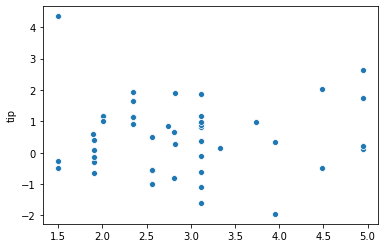

In [178]:
residuals= y_test-y_pred
sns.scatterplot(y_pred,residuals)

## Hyperparameter Tunning with Randomized Search 

In [179]:
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [180]:
hyperparam_space={
    'tree__min_samples_leaf':[1,5,10,15,20,50],
    'tree__max_depth':[2,3,4,5,6,7],
    'tree__criterion':['mse','mae']
                    }

In [181]:
tree= DecisionTreeRegressor(max_depth=5, random_state=2020)
tree_pipe=Pipeline([
    ('transformer', transformer),
    ('tree',tree)
])

In [182]:
random_search= RandomizedSearchCV(
    tree_pipe, #model
    param_distributions=hyperparam_space, #parameter yg ingin ditunning
    n_iter=20, #berapa random parameter yang dicoba
    cv= 5,
    scoring='neg_mean_squared_error', #metric
    random_state=2020,
    n_jobs=-1
)

In [183]:
random_search.fit(X_train_val,y_train_val)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('encoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'day',
                                                                                'time'])])),
                                             ('tree',
                                              DecisionTreeRegressor(max_depth=5,
                                                                    random_state=2020))]),
                   n_iter=20, n_jobs=-1,
   

In [184]:
print('best score :', random_search.best_score_)
print('best param: ', random_search.best_params_)

best score : -0.9829038972124051
best param:  {'tree__min_samples_leaf': 1, 'tree__max_depth': 4, 'tree__criterion': 'mse'}


In [185]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__min_samples_leaf,param_tree__max_depth,param_tree__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032112,0.005692,0.016361,0.002403,1,2,mae,"{'tree__min_samples_leaf': 1, 'tree__max_depth...",-0.738330,-0.851707,-1.323954,-1.509013,-1.356648,-1.155931,0.303358,3
1,0.023138,0.007341,0.013165,0.006321,5,7,mse,"{'tree__min_samples_leaf': 5, 'tree__max_depth...",-1.266981,-0.767827,-1.325200,-2.239966,-1.472244,-1.414444,0.475952,19
2,0.022139,0.007502,0.013366,0.006723,5,4,mse,"{'tree__min_samples_leaf': 5, 'tree__max_depth...",-1.144108,-0.817462,-1.375826,-2.197390,-1.445703,-1.396098,0.456784,18
3,0.033719,0.005721,0.010971,0.002527,20,2,mae,"{'tree__min_samples_leaf': 20, 'tree__max_dept...",-0.722048,-1.093600,-1.182453,-1.955167,-1.356648,-1.261983,0.403899,6
4,0.027345,0.005585,0.017957,0.010701,5,2,mae,"{'tree__min_samples_leaf': 5, 'tree__max_depth...",-0.722048,-1.093600,-1.215538,-1.960931,-1.356648,-1.269753,0.404778,8
5,0.030718,0.013982,0.007779,0.001466,50,7,mse,"{'tree__min_samples_leaf': 50, 'tree__max_dept...",-0.879731,-0.900169,-1.479036,-2.103678,-1.437448,-1.360013,0.450628,12
6,0.025332,0.011675,0.015958,0.012504,1,4,mse,"{'tree__min_samples_leaf': 1, 'tree__max_depth...",-0.771622,-0.665101,-1.593723,-1.029129,-0.854944,-0.982904,0.327795,1
7,0.024134,0.022877,0.010771,0.009596,5,3,mse,"{'tree__min_samples_leaf': 5, 'tree__max_depth...",-0.987999,-0.897975,-1.295115,-2.212884,-1.413923,-1.361579,0.466126,14
8,0.025732,0.009962,0.010373,0.005300,20,4,mae,"{'tree__min_samples_leaf': 20, 'tree__max_dept...",-0.805774,-1.082392,-1.204603,-1.997315,-1.332621,-1.284541,0.396694,9
9,0.020146,0.004478,0.008179,0.002986,1,2,mse,"{'tree__min_samples_leaf': 1, 'tree__max_depth...",-0.816130,-0.882642,-1.424336,-1.108872,-0.924132,-1.031222,0.219261,2


## Final Result Comparison

### Model performance before tunning

In [186]:
tree= DecisionTreeRegressor(max_depth=5, random_state=2020)
tree_pipe=Pipeline([
    ('transformer', transformer),
    ('tree',tree)
])
tree_pipe.fit(X_train_val,y_train_val)
y_pred=tree_pipe.predict(X_test)
print('mse= ', mean_squared_error(y_test,y_pred))

mse=  1.4808803946104498


### Model Preformance After Fitting

In [187]:
random_search.best_estimator_.fit(X_train_val,y_train_val)
y_pred=random_search.best_estimator_.predict(X_test)
print('mse= ', mean_squared_error(y_test,y_pred))

mse=  1.3093536770005814


Ada peningkatan performa model, karena nilai MSE turun dari 1.48 menjadi 1.31

# Information Leakage

In [188]:
rnd= np.random.RandomState(seed=2020)
X=rnd.normal(size=(100,10000))
y=rnd.normal(size=(100, ))

Data dibuat secara random, sehingga, seharusnya tidak terdapat hubungan di antara X dan y

## Kalau salah fitting

In [189]:
from sklearn.feature_selection import SelectPercentile, f_regression

select=SelectPercentile(score_func=f_regression, percentile=5).fit(X,y) #perhatikan apa yang difit
X_selected= select.transform(X)
X_selected.shape

(100, 500)

In [190]:
from sklearn.linear_model import Ridge

In [191]:
cross_val_score(Ridge(),X_selected, y, cv=5)

array([0.92165345, 0.89445668, 0.92827414, 0.93088559, 0.91044624])

In [192]:
Hasil cross validasi (R2) mengindikasikan model yang kita buat sangatlah baik, walaupun  data yg kita masukkan merupakan data random. 

SyntaxError: invalid syntax (<ipython-input-192-ccb5c9116aa2>, line 1)

## Tanpa Leakage

In [67]:
select= SelectPercentile(score_func=f_regression, percentile=5)

pipe=Pipeline([
    ('select', select),
    ('model',Ridge())
])

In [68]:
cross_val_score(pipe,X,y,cv=5)

array([-0.0330359 , -0.07840338, -0.06731106, -0.04544685, -0.07314928])

In [ ]:
Hasil kali ini adalah nilai R2 yang seharusnya dari data random yang kita buat. Nilai R2 sangat kecil, bahkan negatif. Information leakage bisa menyebabkan hasil evaluasi model menjadi terlalu optimis. 

# Algorithm Chain: Adult Dataset

data : adult.csv  
target : income  

preprocess: 
* missing value : simple imputer with constant  
* one hot encoding : relationship, race, sex  
* binary encoding : workclass, marital status, occupation, native country   
* ordinal encoding : education (already encoded)  
* no treatment : numerical  

out : fnlwgt   

Random state 10, data splitting 70:30  
* model Tree(max depth 5,  criterion entropy) and compute f1 using CV  
* Compute another metrics  
* model Logistic Regression (solver liblinear) compute recall +, precision +, f1 +, make ROC and PRC in test set  
* do hyperparameter tuning for logistic regression (optimize C and solver) optimized by f1 and using stratified CV 5 fold   
* compare the result (before and after) in test set   


In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, plot_roc_curve,plot_precision_recall_curve, classification_report


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline

In [81]:
df_adult = pd.read_csv('adult.csv')

In [82]:
df_adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Preprocessor

In [72]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'NC', missing_values='?')), #missing value ditandai dengan apa?
                                    ('binary encoder',ce.BinaryEncoder())
])

transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),['relationship','race','sex']),
                                 ('binary encoder',binary_encoder_pipeline,['workclass','marital.status','occupation','native.country'])
                                ], remainder = 'passthrough')

## Splitting data

In [76]:
X = df_adult.drop(columns = ['fnlwgt','income','education'])
y = np.where(df_adult['income']=='>50K',1,0)

In [141]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    stratify = y, 
    random_state = 10,
    test_size=0.3)

## Model Selection: Benchmark

In [142]:
logreg= LogisticRegression(solver='liblinear')
tree= DecisionTreeClassifier(max_depth=5, criterion='entropy')

In [143]:
estimator= Pipeline([
    ('transformer', transformer),
    ('model',logreg)
])

In [144]:
skfold= StratifiedKFold(n_splits=5)

In [145]:
model_cv=cross_val_score(estimator,X_train_val,y_train_val, scoring='f1', cv=skfold)

In [146]:
print('score: ',model_cv)
print('mean score: ',model_cv.mean())
print('std score: ',model_cv.std())

score:  [0.63710499 0.63971341 0.63523316 0.64368981 0.65339459]
mean score:  0.6418271930924686
std score:  0.006442398722523763


In [147]:
### Flexible metrics and model

def model_evaluation_cv(model,metric):
    skfold= StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess', transformer),
        ('model',model)
    ])
    model_cv=cross_val_score(estimator,X_train_val,y_train_val,cv=skfold, scoring=metric)
    return model_cv

In [148]:
def print_result(model_cv):
    print('score: ',model_cv)
    print('mean score: ',model_cv.mean())
    print('std score: ',model_cv.std())

In [149]:
model= DecisionTreeClassifier(criterion='entropy',random_state=2020)
metric='f1'

model_cv=model_evaluation_cv(model,metric)
print_result(model_cv)

score:  [0.61093538 0.60793358 0.61038961 0.60797034 0.60387812]
mean score:  0.6082214061627219
std score:  0.0024930630561650125


In [150]:
model= LogisticRegression(solver='liblinear')
model_cv=model_evaluation_cv(model,metric)
print_result(model_cv)

score:  [0.63710499 0.63971341 0.63523316 0.64368981 0.65339459]
mean score:  0.6418271930924686
std score:  0.006442398722523763


Logistic regresi dipilih sebagai benchmark

### Model Performance

In [151]:
model= LogisticRegression(solver='liblinear')


In [152]:
estimator= Pipeline([
    ('preprocessing', transformer),
    ('model',logreg)
])

In [153]:
estimator.fit(X_train_val,y_train_val)
y_pred=estimator.predict(X_test)

In [154]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7417
           1       0.75      0.58      0.65      2352

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769



In [155]:
f1_score(y_test,y_pred)

0.6543800861656294

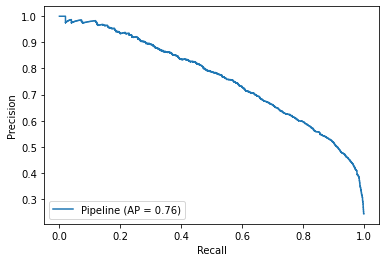

In [119]:
plot_precision_recall_curve(estimator,X_test,y_test)

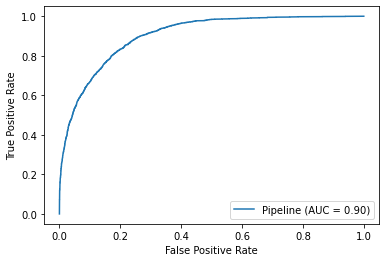

In [120]:
plot_roc_curve(estimator, X_test,y_test)

### Hyperparameter Tunning

In [122]:
model= LogisticRegression(solver='liblinear')
estimator= Pipeline([
    ('preprocessing', transformer),
    ('model',logreg)
])

In [124]:
hyperparam_space={
    'model__solver':['liblinear', 'newton-cg'],
    'model__C':[100,10,1,0.1,0.01,0.001]
}

In [125]:
skfold=StratifiedKFold(n_splits=5)
grid_search=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1'
    ,n_jobs=-1
    )

In [128]:
grid_search.fit(X_train_val,y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
             

In [130]:
print('best_score',grid_search.best_score_)
print('best_param',grid_search.best_params_)

best_score 0.6518301336287953
best_param {'model__C': 100, 'model__solver': 'newton-cg'}


# Final Results Comparison

In [131]:
model= LogisticRegression(solver='liblinear')
estimator= Pipeline([
    ('preprocessing', transformer),
    ('model',logreg)
])
estimator.fit(X_train_val,y_train_val)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                   

#### Before tunning

In [135]:
y_pred=estimator.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      6181
           1       0.75      0.57      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



In [136]:
f1_score(y_test,y_pred)

0.6498988146863255

### After tunning

In [133]:
grid_search.best_estimator_.fit(X_train_val,y_train_val)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                   

In [134]:
y_pred=grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6181
           1       0.75      0.58      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.85      0.85      0.85      8141



In [137]:
f1_score(y_test,y_pred)

0.6498988146863255

## No change in performance after tunning